<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM + sliding window (5)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

#1. data
np.random.seed(42) # 매번 돌릴때마다 같은 결과 나오도록 seed
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# 2. 정규화
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sequence 생성 (시계열 -> 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))  # future step에서의 CPU 예측
model.compile(optimizer='adam', loss='mse')


model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # future_step (5) step 예측
y_true = y_test.reshape(-1, future_steps)



입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)
Epoch 1/50


/tmp/ipython-input-18-2304037617.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0311
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4452e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3037e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.1948e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.0464e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8449e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7465e-04
Epoch 8/50
418/431 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7196e-04

KeyboardInterrupt: 

In [ ]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [ ]:
#1. data
# datapoint 갯수 많으므로 sliding window 방식
np.random.seed(42)
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
# CNN을 더쌓아
from tensorflow.keras.layers import Bidirectional, Dropout

model = Sequential()

# CNN 두 층
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # 추가 CNN
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM --> 양방향 패턴 학습
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # 첫번째 BiLSTM
model.add(Dropout(0.2))  # 과적합 방지
model.add(Bidirectional(LSTM(32)))  # 두번째 BiLSTM

model.add(Dense(64, activation='relu'))  # 추가 Dense
model.add(Dense(future_steps))  # 미래 step 예측

model.compile(optimizer='adam', loss='mse')

print(model.summary())

model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # 미래 5분 예측
y_true = y_test.reshape(-1, future_steps)



In [ ]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


In [ ]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # MAE/RMSE 저장 리스트
fig, ax = plt.subplots(figsize=(15,5))

# True 값은 한 번만 그리기
ax.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # Series 생성 (index 맞춤)
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # 성능 측정
    true_vals_ma = test_series_true.values[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 저장
    results.append((k, mae, rmse))

    # 그래프에 추가
    ax.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)

# CNN-LSTM도 같이 비교
ax.plot(test_series_pred, label="CNN-LSTM", color="red", linewidth=1.2)

# X축 tick 설정
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# k별 성능 출력
print("=== Moving Average 성능 비교 ===")
for k, mae, rmse in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}")


## 3. LSTM + sliding window (1)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 5분 단위 한 달 데이터 생성
np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 하루 288 포인트 (5분 단위)
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# sliding window function, lookback_time만큼을 보고 predict_time만큼 추정
def create_sliding_window_data(data, lookback_time, predict_time):
    X, y = [], []
    for i in range(len(data) - lookback_time - predict_time + 1):
        x_window = data[i:i+lookback_time]
        y_value  = data[i+lookback_time+predict_time-1]
        X.append(x_window)
        y.append(y_value)
    return np.array(X), np.array(y)

lookback = 20  # 과거 20개 step 사용
predict_horizon = 1  # 1 step ahead 예측
X, y = create_sliding_window_data(df['cpu'].values, lookback, predict_horizon)

# LSTM 입력 차원 맞추기: (샘플수, time_steps, feature=1)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"input shape: {x_train.shape}, output shape: {y_train.shape}")

# LSTM 모델 정의
cell_size = 128
timesteps = lookback
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

model.summary()

history = model.fit(x_train, y_train,
                    epochs=100, batch_size=16,
                    validation_data=(x_test, y_test),
                    verbose=1)

y_pred = model.predict(x_test)


input shape: (6896, 20, 1), output shape: (6896, 1)


/tmp/ipython-input-19-32888243.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CPU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1789.6055 - mean_absolute_error: 40.5086 - root_mean_squared_error: 41.9143 - val_loss: 843.6928 - val_mean_absolute_error: 28.2472 - val_root_mean_squared_error: 29.0464
Epoch 2/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 346.6411 - mean_absolute_error: 16.4265 - root_mean_squared_error: 18.5177 - val_loss: 259.5686 - val_mean_absolute_error: 14.6213 - val_root_mean_squared_error: 16.1111
Epoch 3/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 94.3630 - mean_absolute_error: 7.9344 - root_mean_squared_error: 9.7092 - val_loss: 132.1064 - val_mean_absolute_error: 9.3166 - val_root_mean_squared_error: 11.4938
Epoch 4/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 71.9179 - mean_absolute_error: 7.0649 - root_mean_squared_error: 8.4795 - val_loss: 110.9768 - val_mean_absolute_error: 8.2628 - val_root_mean_squared_error: 10.5346
Epoch 5/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 65.7286 - mean_absolu

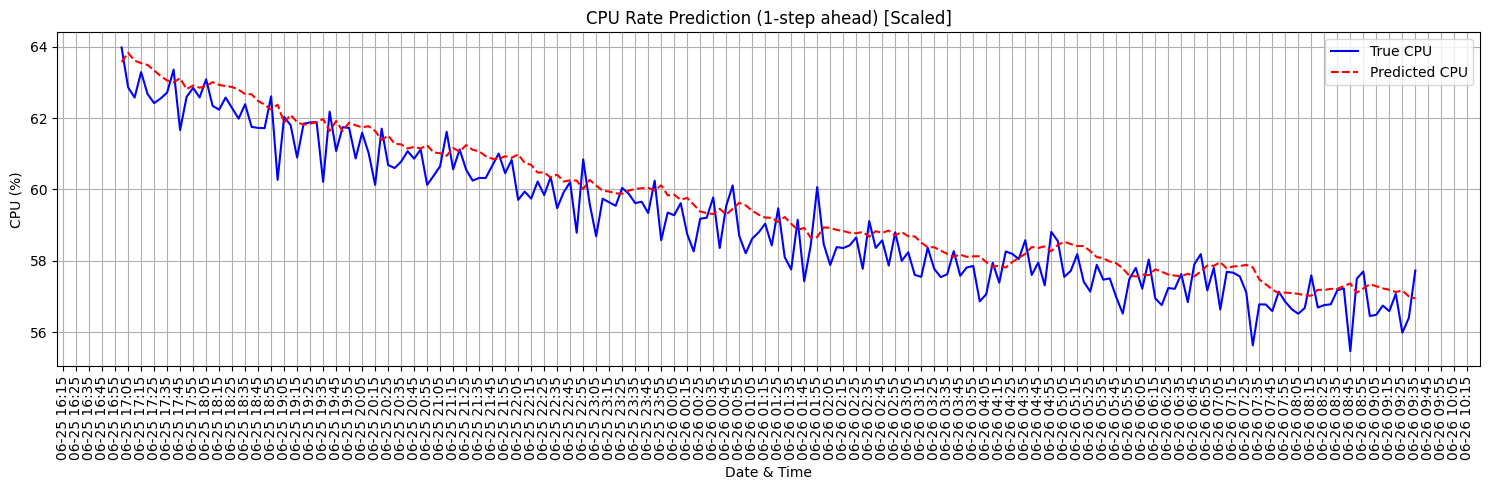

In [ ]:
import matplotlib.dates as mdates

test_start_idx = len(x_train) + lookback
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

y_test_series = pd.Series(y_test.flatten(), index=test_time_index)
y_pred_series = pd.Series(y_pred.flatten(), index=test_time_index)

def plot_with_time(x_true, x_pred, ylabel, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(x_true, label='True CPU', color='blue')
    ax.plot(x_pred, label='Predicted CPU', color='red', linestyle='--')


    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))   # 10분 간격
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # 월-일 시:분 표시

    # x축 라벨 세로(90도 회전)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

    plt.xlabel('Date & Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_with_time(y_test_series[200:400], y_pred_series[200:400],
               ylabel='CPU (%)',
               title='CPU Rate Prediction (1-step ahead) [Scaled]')


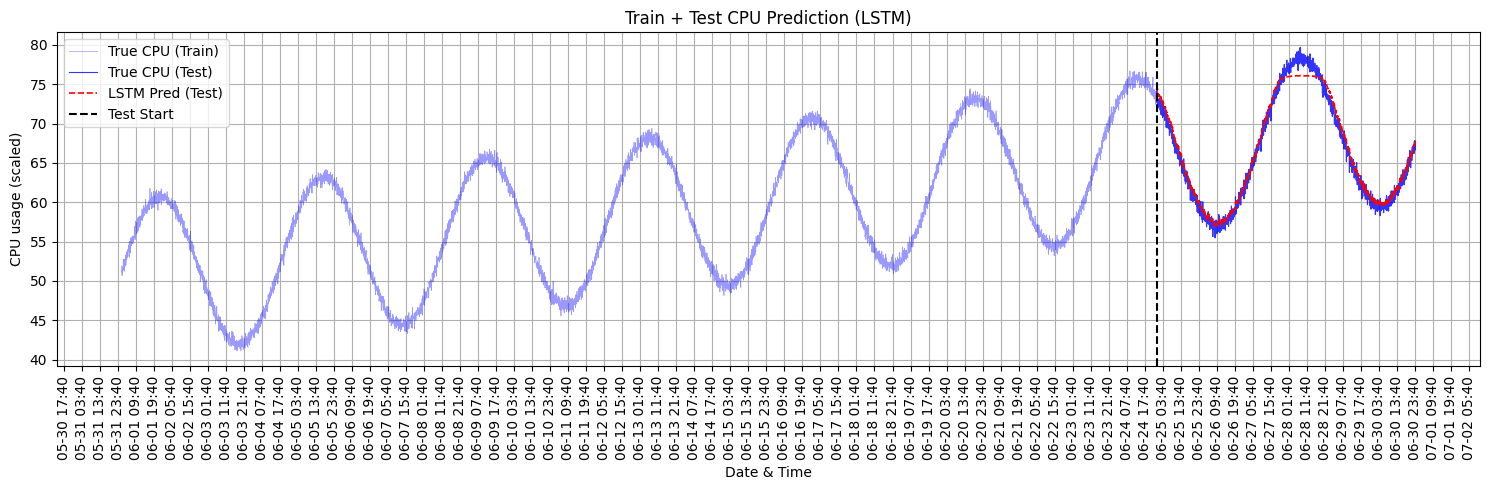

In [ ]:
time_index_all = df.index[lookback:]          # sliding window 후 시간 인덱스
train_end_idx = len(x_train)                  # train 길이
train_time_index = time_index_all[:train_end_idx]
test_time_index  = time_index_all[train_end_idx:]

# Train/Test 실제값 (원본값)
train_true = y_train.flatten()
test_true  = y_test.flatten()

# Train/Test 예측값 (train은 y_train 그대로, test는 y_pred)
train_pred = y_train.flatten()       # LSTM은 train 예측 안 했으니 실제값만
test_pred  = y_pred.flatten()        # LSTM test 예측값

# Pandas Series로 시간축 맞추기
train_series_true = pd.Series(train_true, index=train_time_index)
test_series_true  = pd.Series(test_true, index=test_time_index)
test_series_pred  = pd.Series(test_pred, index=test_time_index)

import matplotlib.dates as mdates

plt.figure(figsize=(15,5))

# Train 구간 실제값
plt.plot(train_series_true.index, train_series_true.values,
         label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)

# Test 구간 실제값
plt.plot(test_series_true.index, test_series_true.values,
         label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)

# Test 구간 예측값
plt.plot(test_series_pred.index, test_series_pred.values,
         label="LSTM Pred (Test)", color="red", linestyle="--", linewidth=1.2)

# Test 시작선 표시
plt.axvline(test_series_true.index[0], color="black", linestyle="--", label="Test Start")

# X축 tick: 10시간 간격
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.xlabel("Date & Time")
plt.ylabel("CPU usage (scaled)")  # 아직 inverse_transform 안 했으면 scaled
plt.title("Train + Test CPU Prediction (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



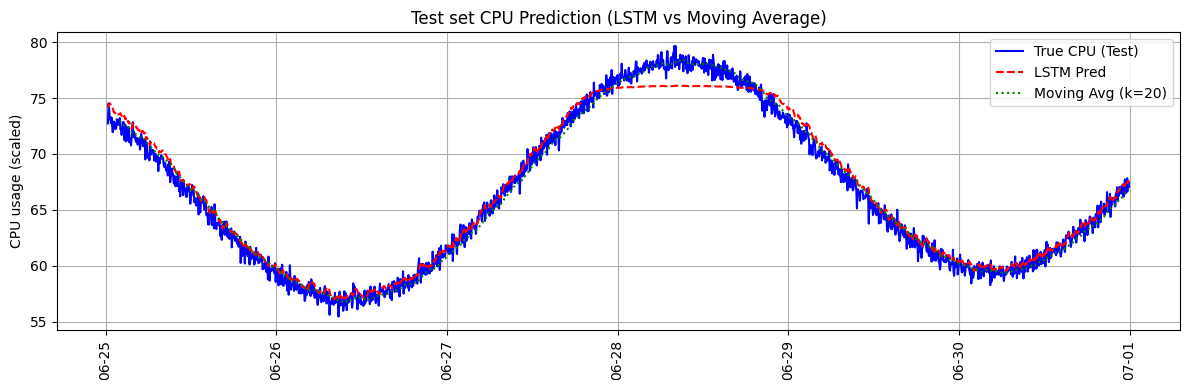

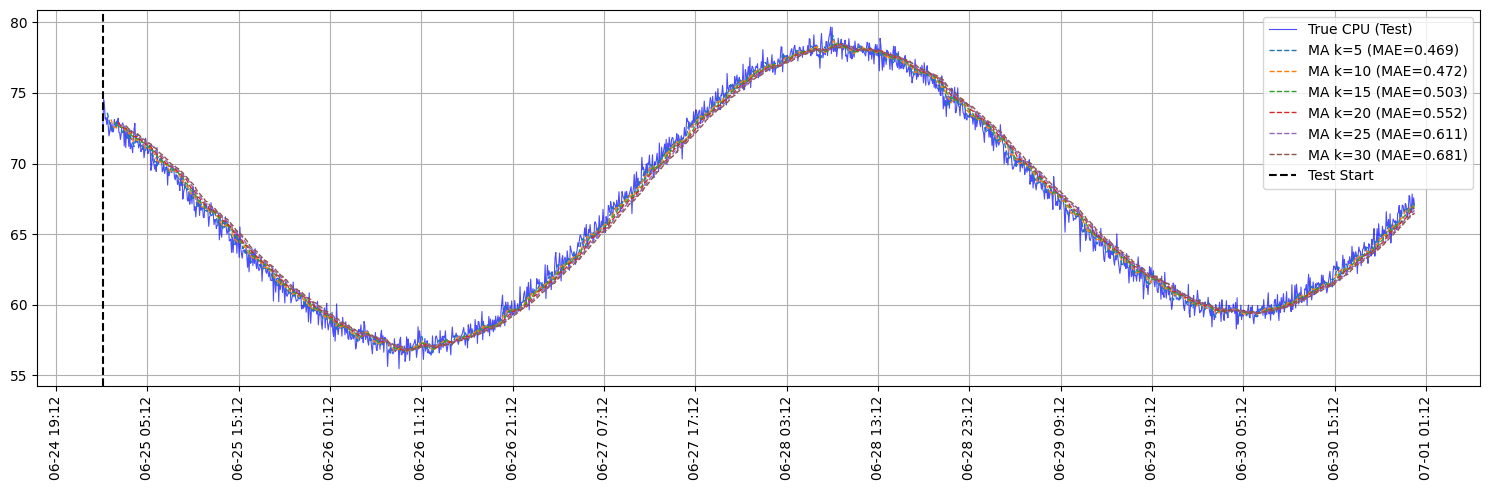

Result of Moving Average
k= 5  MAE=0.4690  RMSE=0.5881  Complexity≈8620 ops
k=10  MAE=0.4720  RMSE=0.5949  Complexity≈17240 ops
k=15  MAE=0.5028  RMSE=0.6326  Complexity≈25860 ops
k=20  MAE=0.5522  RMSE=0.6887  Complexity≈34480 ops
k=25  MAE=0.6113  RMSE=0.7561  Complexity≈43100 ops
k=30  MAE=0.6814  RMSE=0.8302  Complexity≈51720 ops

Result of LSTM
MAE : 0.7625
RMSE: 0.9685


In [ ]:
# mov_avg와 비교, window크기별 분석

# k-step Moving Average for test
k = 20
ma_pred = [np.mean(test_true[i-k:i]) for i in range(k, len(test_true))]
ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

plt.figure(figsize=(12,4))
plt.plot(test_series_true.index, test_series_true.values, label="True CPU (Test)", color="blue")
plt.plot(test_series_pred.index, test_series_pred.values, label="LSTM Pred", color="red", linestyle="--")
plt.plot(ma_pred_series.index, ma_pred_series.values, label=f"Moving Avg (k={k})", color="green", linestyle=":")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.ylabel("CPU usage (scaled)")
plt.title("Test set CPU Prediction (LSTM vs Moving Average)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Result of LSTM
mae_lstm  = mean_absolute_error(test_series_true, test_series_pred)
rmse_lstm = np.sqrt(mean_squared_error(test_series_true, test_series_pred))


k_list = [5, 10, 15, 20, 25, 30]  # moving average window
results = []
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)
N = len(test_series_true)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # index 맞추기 위한 series 생성
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # evaluation
    true_vals_ma = test_series_true.values[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # ✅ Complexity: naive O(N*k)
    complexity = N * k

    # 저장
    results.append((k, mae, rmse, complexity))

    # k별 시계열 그래프도 추가
    ax.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)


ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# k별 성능 출력
print("Result of Moving Average")
for k, mae, rmse, comp in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{comp} ops")


print("\nResult of LSTM")
print(f"MAE : {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")


## 결과 비교 그래프

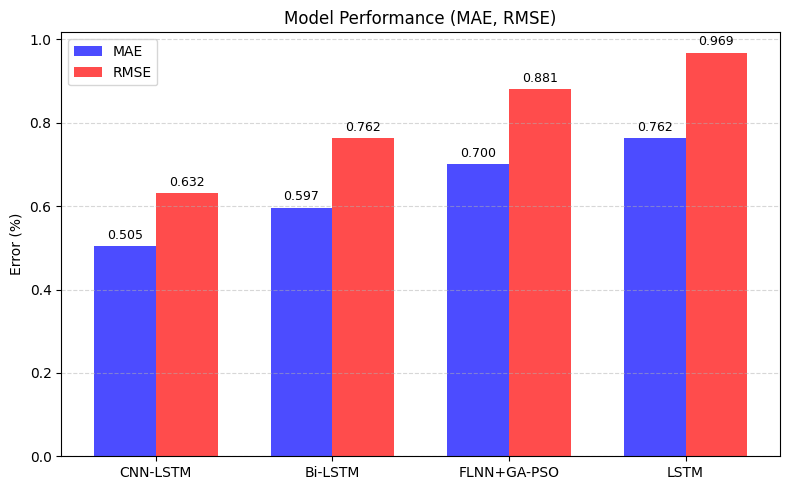

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 이름
models = ["CNN-LSTM", "Bi-LSTM", "FLNN+GA-PSO", "LSTM"]

# MAE와 RMSE 값
mae_vals = [0.5051, 0.5966, 0.7, 0.7625]
rmse_vals = [0.6320, 0.7623, 0.881, 0.9685]

x = np.arange(len(models))  # x축 위치
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(8,5))

# MAE와 RMSE 막대 나란히 표시
rects1 = ax.bar(x - width/2, mae_vals, width, label='MAE', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, rmse_vals, width, label='RMSE', color='red', alpha=0.7)

# 라벨/타이틀 설정
ax.set_ylabel('Error (%)')
ax.set_title('Model Performance (MAE, RMSE)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 각 막대 위에 값 표시
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),  # 막대 위쪽 3px
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



## 그래프 모양 변경 (비대칭 sin파)

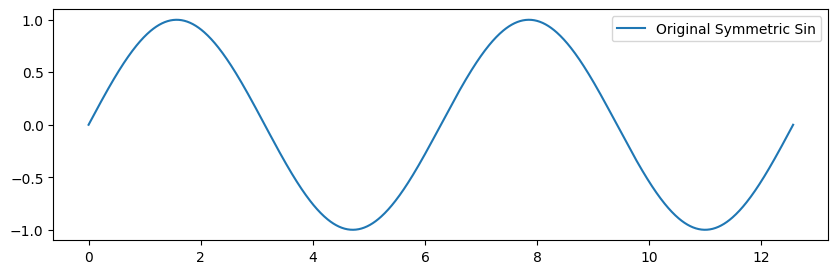

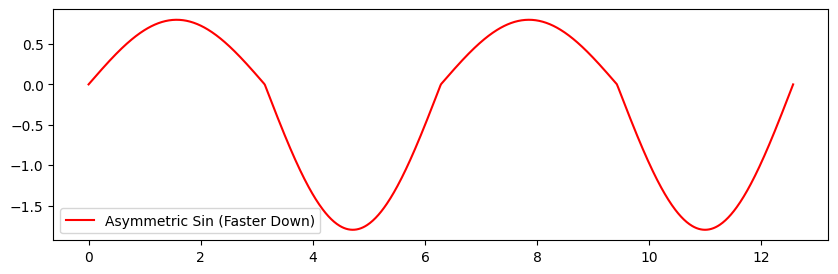

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 길이
total_points = 1000
theta = np.linspace(0, 4*np.pi, total_points)  # 여러 주기 생성

# 기존 사인파 (대칭)
wave = np.sin(theta)

plt.figure(figsize=(10,3))
plt.plot(theta, wave, label="Original Symmetric Sin")
plt.legend()
plt.show()

# 비대칭 처리: 내려갈 때(음수)만 더 크게
asym_wave = np.where(wave < 0, wave * 1.8, wave * 0.8)  # 음수 구간 *1.8배 확대, 양수 구간 *0.8

plt.figure(figsize=(10,3))
plt.plot(theta, asym_wave, label="Asymmetric Sin (Faster Down)", color='red')
plt.legend()
plt.show()


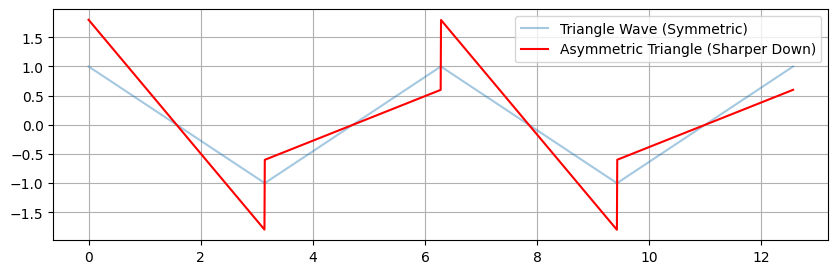

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

total_points = 2000
theta = np.linspace(0, 4*np.pi, total_points)

# 기본 삼각파 생성 (대칭)
triangle = 2 * np.abs((theta / np.pi) % 2 - 1) - 1

# 비대칭: 하강 구간 가속, 상승 구간 느리게
asym_triangle = np.where(np.gradient(triangle) < 0, triangle * 1.8, triangle * 0.6)

plt.figure(figsize=(10,3))
plt.plot(theta, triangle, label="Triangle Wave (Symmetric)", alpha=0.4)
plt.plot(theta, asym_triangle, label="Asymmetric Triangle (Sharper Down)", color='red')
plt.legend()
plt.grid(True)
plt.show()


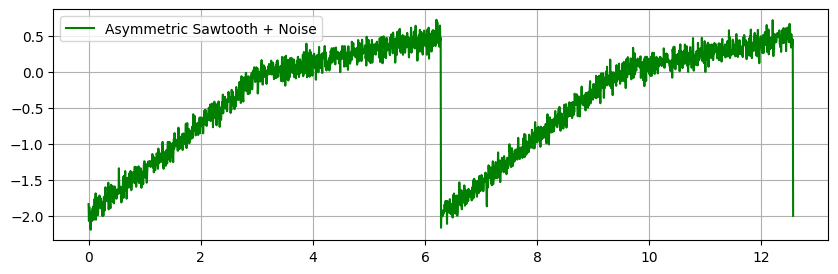

In [ ]:
from scipy.signal import sawtooth

# sawtooth 생성
saw = sawtooth(theta)

# 랜덤 잡음 추가 → 불규칙
saw_asym = np.where(saw < 0, saw * 2.0, saw * 0.5) + np.random.normal(0, 0.1, total_points)

plt.figure(figsize=(10,3))
plt.plot(theta, saw_asym, label="Asymmetric Sawtooth + Noise", color='green')
plt.legend()
plt.grid(True)
plt.show()


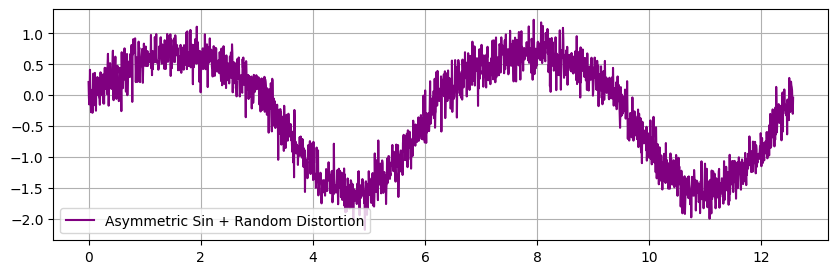

In [ ]:
# 기본 Sin
wave = np.sin(theta)

# 비대칭 + 랜덤 노이즈로 불규칙하게
wave_asym = np.where(wave < 0, wave * np.random.uniform(1.5,2.0), wave * np.random.uniform(0.5,0.8))
wave_asym += np.random.normal(0, 0.2, total_points)  # 추가 잡음

plt.figure(figsize=(10,3))
plt.plot(theta, wave_asym, label="Asymmetric Sin + Random Distortion", color='purple')
plt.legend()
plt.grid(True)
plt.show()


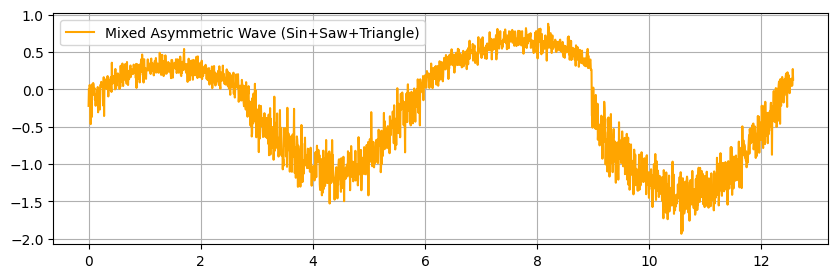

In [ ]:
# 여러 파형 합쳐서 더 복잡하게
mix_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.7) +
    0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
    np.random.normal(0, 0.1, total_points)
)

# 하강 구간만 더 키움
mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

plt.figure(figsize=(10,3))
plt.plot(theta, mix_wave, label="Mixed Asymmetric Wave (Sin+Saw+Triangle)", color='orange')
plt.legend()
plt.grid(True)
plt.show()


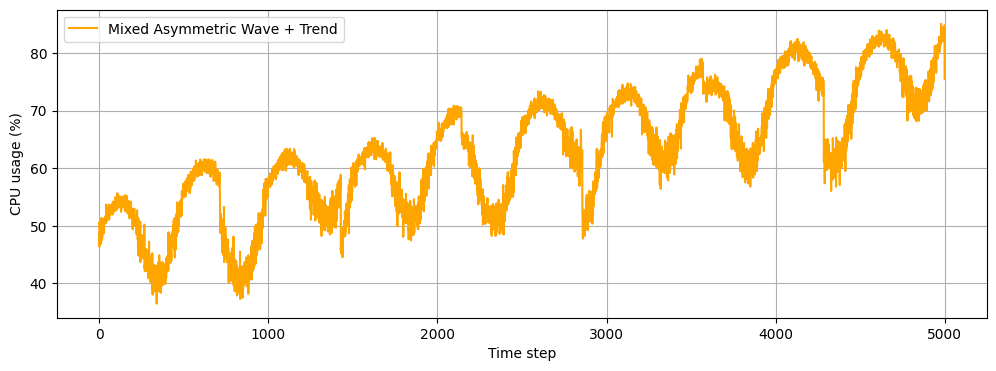

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

# 더 긴 시간축
total_points = 5000                  # 더 긴 데이터
theta = np.linspace(0, 20*np.pi, total_points)  # 주기를 더 길게 (20π)

# 여러 파형 합성 (Sin + Sawtooth + Triangle + Noise)
mix_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.7) +
    0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
    np.random.normal(0, 0.1, total_points)    # 불규칙성
)

# 하강 구간만 더 크게 (비대칭)
mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# ✅ 시간 경과에 따른 증가 추세 추가
trend = np.linspace(0, 30, total_points)  # 점점 증가하는 선형 트렌드

# 최종 CPU 패턴 (50% 기본값 + 파형 + 증가추세)
cpu_usage = 50 + 10 * mix_wave + trend

# 그래프 출력
plt.figure(figsize=(12,4))
plt.plot(cpu_usage, label="Mixed Asymmetric Wave + Trend", color='orange')
plt.xlabel("Time step")
plt.ylabel("CPU usage (%)")
plt.legend()
plt.grid(True)
plt.show()


##복잡한 데이터 (peak data) + CNN-LSTM

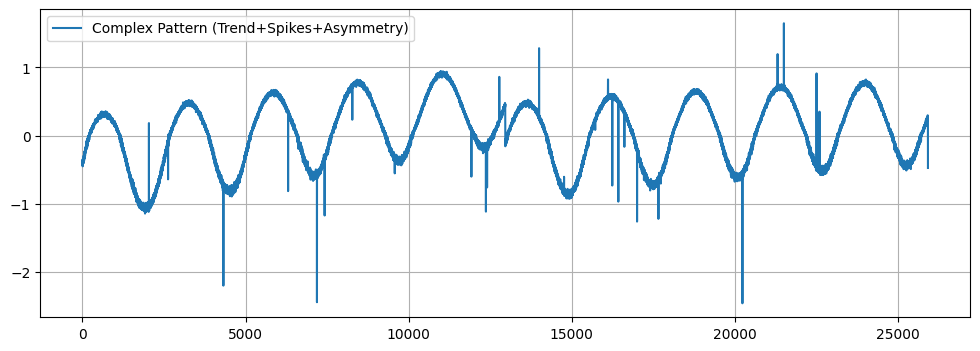

In [49]:
theta = np.linspace(0, 20*np.pi, total_points)

# 1) 기본 주기 + 느린 변동 추가
base_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.2) +
    np.random.normal(0, 0.02, total_points)
)

# 2) 주기가 천천히 변하는 sin(비선형)
long_wave = 0.2 * np.sin(theta * 0.05)  # 매우 긴 주기 (trend-like)

# 3) random spike
spikes = np.zeros_like(theta)
rand_idx = np.random.choice(len(theta), size=30, replace=False)  # 랜덤 몇 개?
spikes[rand_idx] = np.random.uniform(-1.5, 1.5, size=30)

# 최종 혼합
mix_wave = base_wave + long_wave + spikes

# 하강구간만 살짝 더 가팔라지게
mix_wave = np.where(mix_wave < 0, mix_wave * 1.4, mix_wave * 0.9)

plt.figure(figsize=(12,4))
plt.plot(mix_wave, label="Complex Pattern (Trend+Spikes+Asymmetry)")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 1. data
np.random.seed(42)
days = 90   # 5분 단위 한 달 데이터
points_per_day = 24 * 12  # 하루 288 포인트
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

theta = np.linspace(0, 20*np.pi, total_points)

# 1) 기본 주기 + 느린 변동 추가
base_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.2) +
    np.random.normal(0, 0.02, total_points)
)

# 2) 주기가 천천히 변하는 sin(비선형)
long_wave = 0.2 * np.sin(theta * 0.05)

# 3) spike
spikes = np.zeros_like(theta)
rand_idx = np.random.choice(len(theta), size=30, replace=False)
spikes[rand_idx] = np.random.uniform(-1.5, 1.5, size=30)

# mix
mix_wave = base_wave + long_wave + spikes

# 하강구간만 더 가파르게
mix_wave = np.where(mix_wave < 0, mix_wave * 1.4, mix_wave * 0.9)

# 시계열 index 관리 위해 dataframe 활용
df = pd.DataFrame({'timestamp': time_index, 'cpu': mix_wave})
df.set_index('timestamp', inplace=True)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sliding window 데이터 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 10 # 한번에 추측하는 단위 (다음 future interval * future steps 만큼을 한번에 추측)
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 4. CNN-LSTM 모델
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))
model.compile(optimizer='adam', loss='mse')

model.fit(
    X_train,
    y_train.reshape((y_train.shape[0], -1)),
    epochs=50,
    batch_size=16,
    verbose=1
)

pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)
y_true = y_test.reshape(-1, future_steps)

print("예측 완료:", pred.shape, y_true.shape)


/tmp/ipython-input-50-1870304758.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


입력 X_train shape: (20712, 20, 1), 출력 y_train shape: (20712, 10, 1)
Epoch 1/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0220
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.8055e-04
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4974e-04
Epoch 4/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7911e-04
Epoch 5/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.5333e-04
Epoch 6/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8185e-04
Epoch 7/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7225e-04
Epoch 8/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7173e-04
Epoch 9/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.6126e-04
Epoch 10/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5404e-04
Epoch 11/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5488e-04
Epoch 12/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5992e-04
Epoch 13/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - 

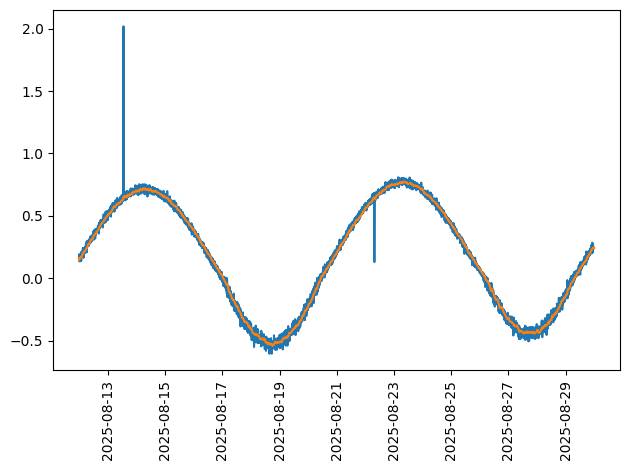

In [51]:

future_interval = 5  # 하나의 step이 실제로는 몇 분 간격인가?

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


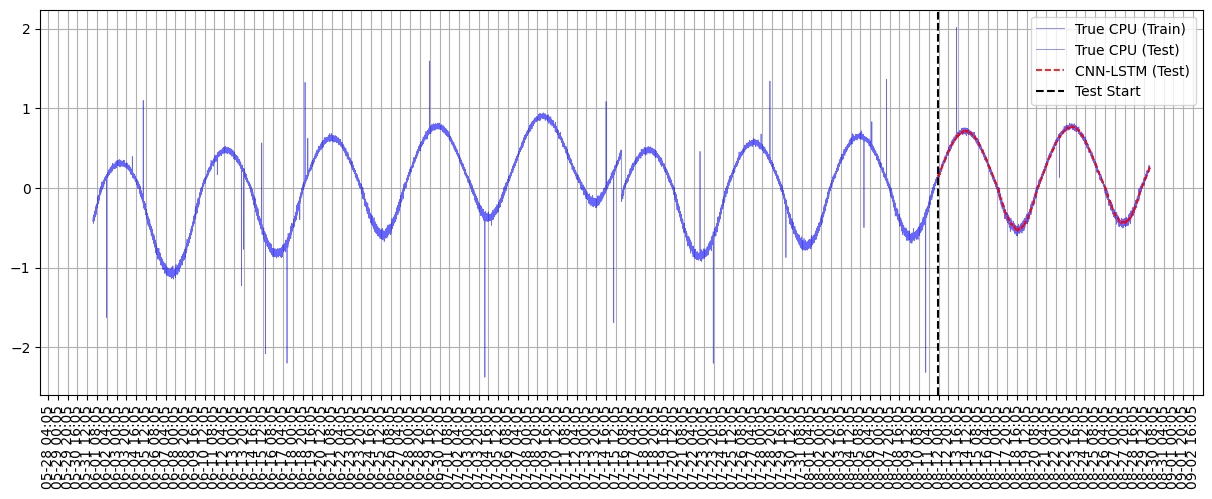

In [52]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


Result for Moving Average
MAE : 0.0201
RMSE: 0.0325

Result for CNN-LSTM
MAE : 0.0194
RMSE: 0.0317


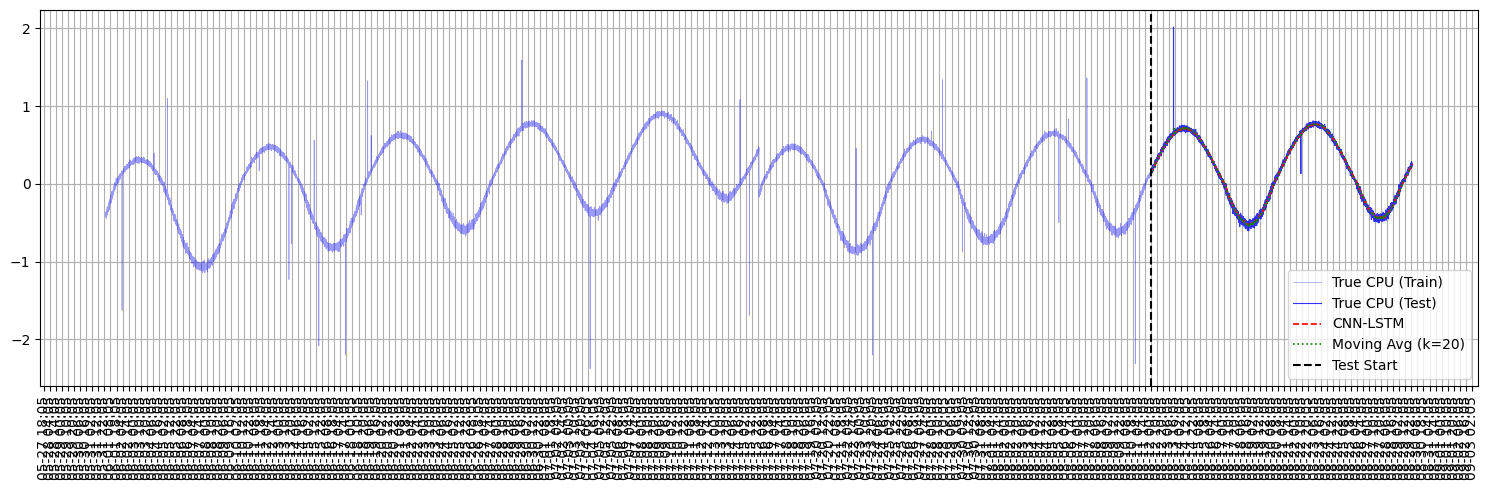

In [53]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

# 매 step마다 MAE 계산
print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


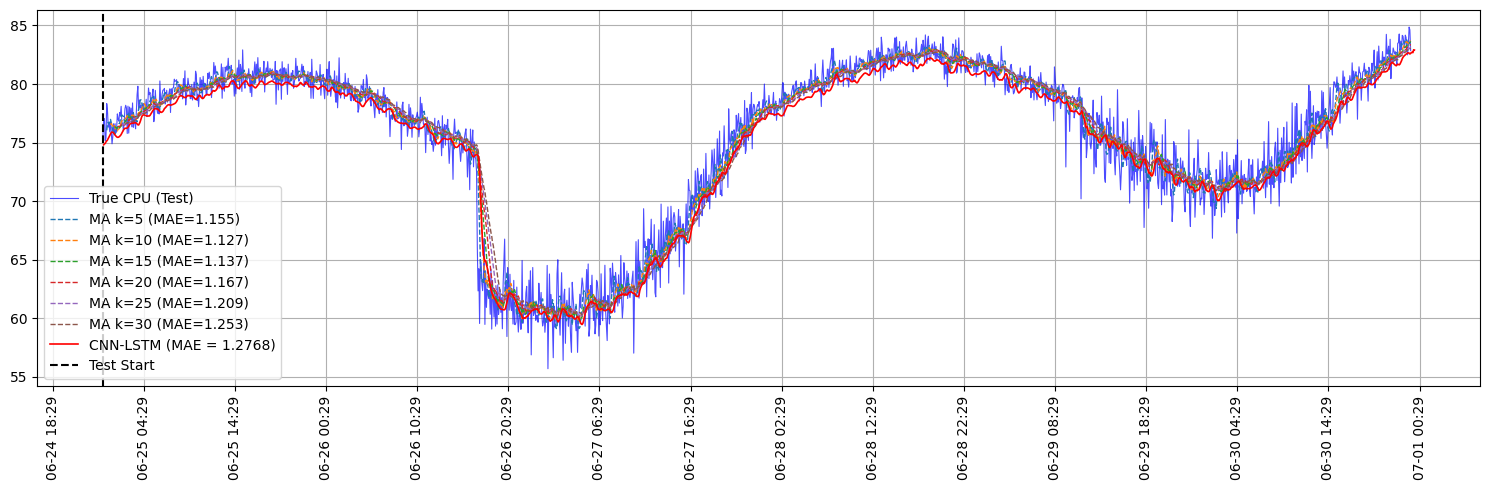

=== Moving Average 성능 비교 ===
k= 5  MAE=1.1552  RMSE=1.5795
k=10  MAE=1.1265  RMSE=1.5650
k=15  MAE=1.1366  RMSE=1.5997
k=20  MAE=1.1670  RMSE=1.6607
k=25  MAE=1.2086  RMSE=1.7383
k=30  MAE=1.2535  RMSE=1.8207


In [19]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # MAE/RMSE 저장 리스트
fig, ax = plt.subplots(figsize=(15,5))

# True 값은 한 번만 그리기
ax.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # Series 생성 (index 맞춤)
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # 성능 측정
    true_vals_ma = test_series_true.values[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 저장
    results.append((k, mae, rmse))

    # 그래프에 추가
    ax.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)

# CNN-LSTM도 같이 비교
ax.plot(test_series_pred, label="CNN-LSTM (MAE = 1.2768)", color="red", linewidth=1.2)

# X축 tick 설정
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# k별 성능 출력
print("=== Moving Average 성능 비교 ===")
for k, mae, rmse in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}")


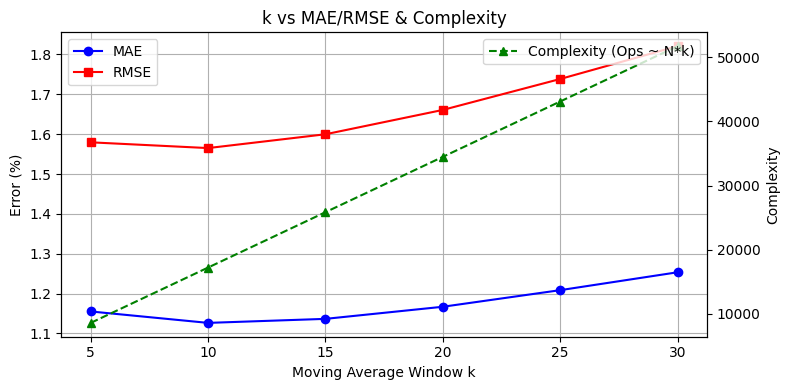

k= 5  MAE=1.1552  RMSE=1.5795  Complexity≈8615 ops
k=10  MAE=1.1265  RMSE=1.5650  Complexity≈17230 ops
k=15  MAE=1.1366  RMSE=1.5997  Complexity≈25845 ops
k=20  MAE=1.1670  RMSE=1.6607  Complexity≈34460 ops
k=25  MAE=1.2086  RMSE=1.7383  Complexity≈43075 ops
k=30  MAE=1.2535  RMSE=1.8207  Complexity≈51690 ops


In [20]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error (%)")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


## FLNN + GA-PSO + peak data

In [54]:
!pip install numpy deap pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
